In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.decomposition import LatentDirichletAllocation
import spacy
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, TimeDistributed, Flatten, Dropout, Conv1D, MaxPooling1D, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Concatenate, Input
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [2]:
# Load the dataset
file_path_csv = 'dataset/gold_prices_with_news.csv'
data = pd.read_csv(file_path_csv)

# Combine all headlines for each date into a single text
data['Headlines'] = data[['Headline 1', 'Headline 2', 'Headline 3', 'Headline 4']].apply(lambda x: ' '.join(x.dropna()), axis=1)

# Extract relevant columns
data = data[['Date', 'Closing Price', 'Headlines']]

# Convert date to datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')

# Sort by date
data = data.sort_values('Date')

# Fill missing headlines with empty string
data['Headlines'] = data['Headlines'].fillna('')

In [3]:
# Sentiment Analysis
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()
data['Sentiment'] = data['Headlines'].apply(lambda x: sid.polarity_scores(x)['compound'])

# Topic Modeling
vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = vectorizer.fit_transform(data['Headlines'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X_tfidf)
data['Topic'] = lda.transform(X_tfidf).argmax(axis=1)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [4]:
# Named Entity Recognition (NER)
nlp = spacy.load('en_core_web_sm')
data['Entities'] = data['Headlines'].apply(lambda x: [(ent.text, ent.label_) for ent in nlp(x).ents])

# Prepare Data for LSTM Model
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['Headlines'])
sequences = tokenizer.texts_to_sequences(data['Headlines'])
word_index = tokenizer.word_index

maxlen = 100
X = pad_sequences(sequences, maxlen=maxlen)

In [5]:
# Normalize the target variable
scaler = MinMaxScaler()
data['Closing Price Scaled'] = scaler.fit_transform(data[['Closing Price']])

# Use the closing price of the previous day as the target
y = data['Closing Price Scaled'].shift(-1).fillna(method='ffill')

In [6]:
# Create sequences for the LSTM model with a window size
window_size = 5
X_windowed = []
y_windowed = []

# Prepare sentiment scores as a feature
sentiment_scores = data['Sentiment'].values

# Example: Binary feature for the presence of a specific entity (e.g., "Gold")
data['Contains_Gold'] = data['Entities'].apply(lambda entities: any('Gold' in entity for entity in entities))
named_entity_features = data[['Contains_Gold']].values

# Combine with sentiment scores and entity features
combined_features = np.hstack((X, sentiment_scores.reshape(-1, 1), named_entity_features))

In [7]:
for i in range(len(combined_features) - window_size):
    X_windowed.append(combined_features[i:i + window_size])
    y_windowed.append(y.iloc[i + window_size])

X_windowed = np.array(X_windowed)
y_windowed = np.array(y_windowed)

X_train, X_test, y_train, y_test = train_test_split(X_windowed, y_windowed, test_size=0.2, random_state=42)

In [8]:
def create_model(model_type):
    # Define input layers
    headline_input = Input(shape=(window_size, maxlen), name='headline_input')
    sentiment_input = Input(shape=(window_size, 1), name='sentiment_input')
    entity_input = Input(shape=(window_size, 1), name='entity_input')
    
    # Embedding and LSTM for headlines
    x = TimeDistributed(Embedding(input_dim=len(word_index) + 1, output_dim=100, input_length=maxlen))(headline_input)

    if model_type == 'Bi-LSTM':
        x = TimeDistributed(Bidirectional(LSTM(100, return_sequences=True)))(x)
    elif model_type == 'CNN':
        x = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'))(x)
        x = TimeDistributed(MaxPooling1D(pool_size=2))(x)
    elif model_type == 'RNN':
        x = TimeDistributed(GRU(100, return_sequences=True))(x)
    else:
        raise ValueError("Invalid model type. Choose from 'Bi-LSTM', 'CNN', or 'RNN'.")

    x = TimeDistributed(Dropout(0.2))(x)
    x = TimeDistributed(Flatten())(x)

    combined = Concatenate(axis=-1)([x, sentiment_input, entity_input])
    
    # Further LSTM layers
    combined = LSTM(100)(combined)
    combined = Dropout(0.2)(combined)
    output = Dense(1)(combined)

    # Define and compile the model
    model = tf.keras.Model(inputs=[headline_input, sentiment_input, entity_input], outputs=output)
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

In [9]:
def train_and_evaluate(model, model_name):
    early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
    history = model.fit(
        [X_train[:, :, :maxlen], X_train[:, :, maxlen].reshape(-1, window_size, 1), X_train[:, :, maxlen + 1].reshape(-1, window_size, 1)],
        y_train,
        epochs=100,
        batch_size=32,
        validation_data=([X_test[:, :, :maxlen], X_test[:, :, maxlen].reshape(-1, window_size, 1), X_test[:, :, maxlen + 1].reshape(-1, window_size, 1)], y_test),
        callbacks=[early_stopping]
    )

    # Predicting on the test set
    y_pred = model.predict([X_test[:, :, :maxlen], X_test[:, :, maxlen].reshape(-1, window_size, 1), X_test[:, :, maxlen + 1].reshape(-1, window_size, 1)])

    # Inverse transform the predicted values to original scale
    y_pred_inverse = scaler.inverse_transform(y_pred)
    y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Evaluate the model
    mse = mean_squared_error(y_test_inverse, y_pred_inverse)
    mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
    print(f'{model_name} - Mean Squared Error: {mse}')
    print(f'{model_name} - Mean Absolute Error: {mae}')

    return y_test_inverse, y_pred_inverse, mse, mae, history

In [10]:
# Train and evaluate Bi-LSTM model
bi_lstm_model = create_model('Bi-LSTM')
y_test_inverse_bi_lstm, y_pred_inverse_bi_lstm, mse_bi_lstm, mae_bi_lstm, history_bi_lstm = train_and_evaluate(bi_lstm_model, 'Bi-LSTM')

# Train and evaluate CNN model
cnn_model = create_model('CNN')
y_test_inverse_cnn, y_pred_inverse_cnn, mse_cnn, mae_cnn, history_cnn = train_and_evaluate(cnn_model, 'CNN')

# Train and evaluate RNN model
rnn_model = create_model('RNN')
y_test_inverse_rnn, y_pred_inverse_rnn, mse_rnn, mae_rnn, history_rnn = train_and_evaluate(rnn_model, 'RNN')

Epoch 1/100
25/25 [==============================] - 20s 678ms/step - loss: 0.1502 - val_loss: 0.0298
Epoch 2/100
25/25 [==============================] - 18s 704ms/step - loss: 0.0171 - val_loss: 0.0094
Epoch 3/100
25/25 [==============================] - 17s 696ms/step - loss: 0.0066 - val_loss: 0.0054
Epoch 4/100
25/25 [==============================] - 17s 673ms/step - loss: 0.0039 - val_loss: 0.0031
Epoch 5/100
25/25 [==============================] - 17s 671ms/step - loss: 0.0029 - val_loss: 0.0025
Epoch 6/100
25/25 [==============================] - 17s 700ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 7/100
25/25 [==============================] - 17s 692ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 8/100
25/25 [==============================] - 17s 694ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 9/100
25/25 [==============================] - 17s 699ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 10/100
25/25 [==============================] - 17s 679ms/step - loss: 0.001

In [11]:
# Calculate MAE and MSE percentages
mean_actual = np.mean(y_test_inverse_bi_lstm)
mae_bi_lstm_pct = (mae_bi_lstm / mean_actual) * 100
mse_bi_lstm_pct = (mse_bi_lstm / mean_actual) * 100

mae_cnn_pct = (mae_cnn / mean_actual) * 100
mse_cnn_pct = (mse_cnn / mean_actual) * 100

mae_rnn_pct = (mae_rnn / mean_actual) * 100
mse_rnn_pct = (mse_rnn / mean_actual) * 100

# Calculate Accuracy
accuracy_bi_lstm = 100 - mae_bi_lstm_pct
accuracy_cnn = 100 - mae_cnn_pct
accuracy_rnn = 100 - mae_rnn_pct

In [12]:
# Print MAE, MSE percentages and accuracies
print(f'Bi-LSTM - MAE: {mae_bi_lstm_pct}%, MSE: {mse_bi_lstm_pct}%, Accuracy: {accuracy_bi_lstm}%')
print(f'CNN - MAE: {mae_cnn_pct}%, MSE: {mse_cnn_pct}%, Accuracy: {accuracy_cnn}%')
print(f'RNN - MAE: {mae_rnn_pct}%, MSE: {mse_rnn_pct}%, Accuracy: {accuracy_rnn}%')

Bi-LSTM - MAE: 1.5273882350910295%, MSE: 65.02002564007456%, Accuracy: 98.47261176490898%
CNN - MAE: 1.1127668231293522%, MSE: 36.0536202439555%, Accuracy: 98.88723317687065%
RNN - MAE: 1.328098643561922%, MSE: 51.010738812696424%, Accuracy: 98.67190135643808%


Text(0.5, 1.0, 'MAE Percentage for Models')

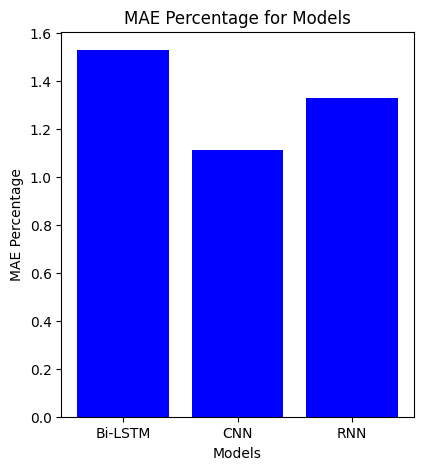

In [13]:
# Plot bar graph for MAE and MSE percentages
models = ['Bi-LSTM', 'CNN', 'RNN']
mae_percentages = [mae_bi_lstm_pct, mae_cnn_pct, mae_rnn_pct]
mse_percentages = [mse_bi_lstm_pct, mse_cnn_pct, mse_rnn_pct]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(models, mae_percentages, color='blue')
plt.xlabel('Models')
plt.ylabel('MAE Percentage')
plt.title('MAE Percentage for Models')

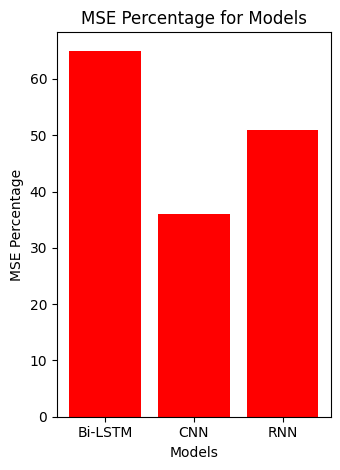

In [14]:
plt.subplot(1, 2, 2)
plt.bar(models, mse_percentages, color='red')
plt.xlabel('Models')
plt.ylabel('MSE Percentage')
plt.title('MSE Percentage for Models')

plt.tight_layout()
plt.show()

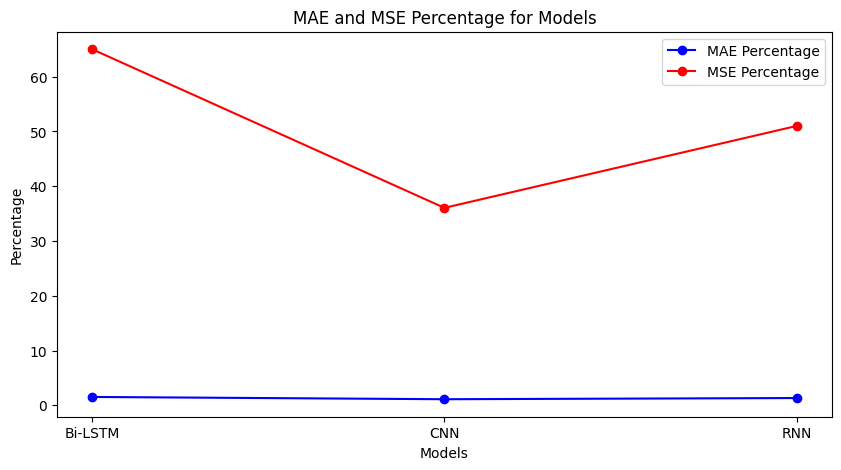

In [15]:
# Plot line graph for MAE and MSE
plt.figure(figsize=(10, 5))
plt.plot(models, mae_percentages, marker='o', label='MAE Percentage', color='blue')
plt.plot(models, mse_percentages, marker='o', label='MSE Percentage', color='red')
plt.xlabel('Models')
plt.ylabel('Percentage')
plt.title('MAE and MSE Percentage for Models')
plt.legend()
plt.show()

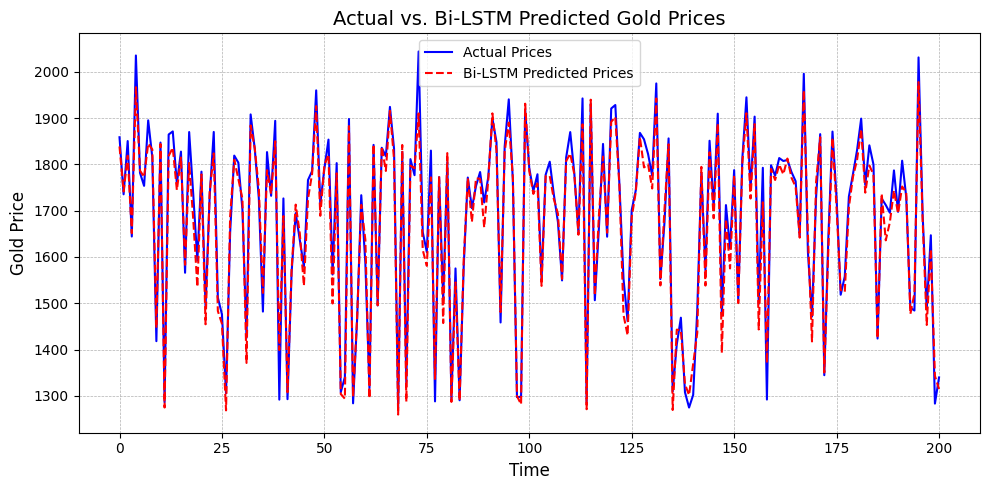

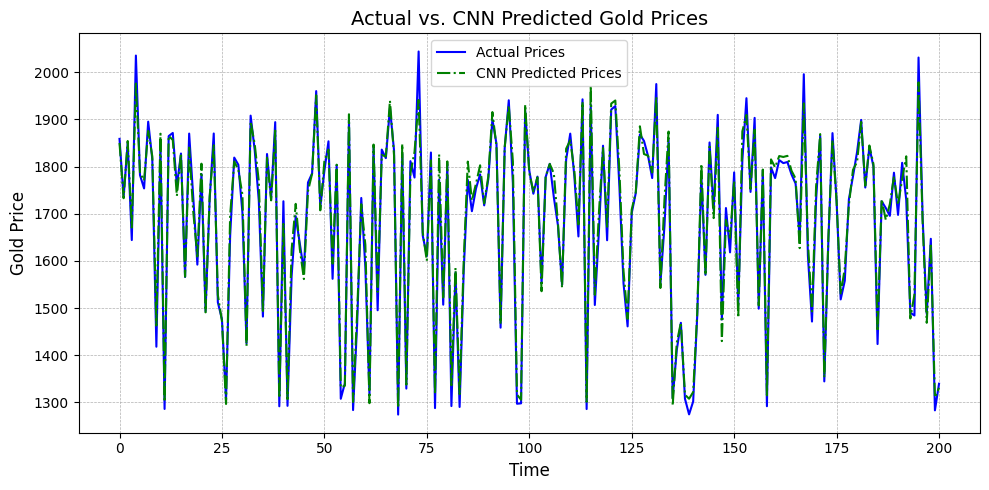

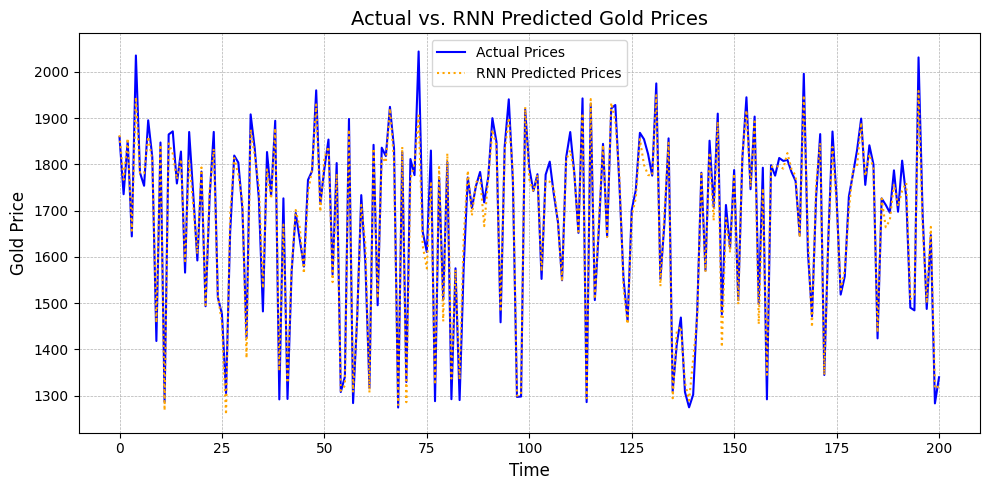

In [16]:
# Plot for Bi-LSTM Predicted Prices
plt.figure(figsize=(10, 5))
plt.plot(range(len(y_test_inverse_bi_lstm)), y_test_inverse_bi_lstm, label='Actual Prices', color='blue', linewidth=1.5)
plt.plot(range(len(y_pred_inverse_bi_lstm)), y_pred_inverse_bi_lstm, label='Bi-LSTM Predicted Prices', color='red', linestyle='--', linewidth=1.5)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Gold Price', fontsize=12)
plt.title('Actual vs. Bi-LSTM Predicted Gold Prices', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='best', fontsize=10)
plt.tight_layout()
plt.show()

# Plot for CNN Predicted Prices
plt.figure(figsize=(10, 5))
plt.plot(range(len(y_test_inverse_bi_lstm)), y_test_inverse_bi_lstm, label='Actual Prices', color='blue', linewidth=1.5)
plt.plot(range(len(y_pred_inverse_cnn)), y_pred_inverse_cnn, label='CNN Predicted Prices', color='green', linestyle='-.', linewidth=1.5)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Gold Price', fontsize=12)
plt.title('Actual vs. CNN Predicted Gold Prices', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='best', fontsize=10)
plt.tight_layout()
plt.show()

# Plot for RNN Predicted Prices
plt.figure(figsize=(10, 5))
plt.plot(range(len(y_test_inverse_bi_lstm)), y_test_inverse_bi_lstm, label='Actual Prices', color='blue', linewidth=1.5)
plt.plot(range(len(y_pred_inverse_rnn)), y_pred_inverse_rnn, label='RNN Predicted Prices', color='orange', linestyle=':', linewidth=1.5)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Gold Price', fontsize=12)
plt.title('Actual vs. RNN Predicted Gold Prices', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='best', fontsize=10)
plt.tight_layout()
plt.show()